<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Libraries-and-Load-Data" data-toc-modified-id="Import-Libraries-and-Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Libraries and Load Data</a></span></li><li><span><a href="#Treat-Missing-Data" data-toc-modified-id="Treat-Missing-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Treat Missing Data</a></span></li><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Preparation</a></span></li><li><span><a href="#Build-word2vec-Embeddings-for-Products" data-toc-modified-id="Build-word2vec-Embeddings-for-Products-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Build word2vec Embeddings for Products</a></span></li><li><span><a href="#Visualize-word2vec-Embeddings" data-toc-modified-id="Visualize-word2vec-Embeddings-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualize word2vec Embeddings</a></span></li><li><span><a href="#Start-Recommending-Products" data-toc-modified-id="Start-Recommending-Products-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Start Recommending Products</a></span></li></ul></div>

## Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import random
from IPython.display import Image, set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
from tqdm import tqdm
!pip install gensim==4.1.2
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

     |████████████████████████████████| 24.1 MB 36.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [2]:
df = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx") #'Online Retail.xlsx')

Let's take a quick look at our data. You can __download it from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/00352/).__

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Given below is the description of the fields in this dataset:

1. __InvoiceNo:__ Invoice number, a unique number assigned to each transaction.

2. __StockCode:__ Product/item code. a unique number assigned to each distinct product.

3. __Description:__ Product description

4. __Quantity:__ The quantities of each product per transaction.

5. __InvoiceDate:__ Invoice Date and time. The day and time when each transaction was generated.

6. __CustomerID:__ Customer number, a unique number assigned to each customer.

In [4]:
df.shape

(541909, 8)

The dataset contains 541,909 transactions. That is a pretty good number for us.

## Treat Missing Data

In [5]:
# check for missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

<br>
Since we have sufficient data, we will drop all the rows with missing values.

In [6]:
# remove missing values
df.dropna(inplace=True)

# again check missing values
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

## Data Preparation

Let's convert the StockCode to string datatype.

In [7]:
df['StockCode']= df['StockCode'].astype(str)

Let's check out the number of unique customers in our dataset.

In [8]:
customers = df["CustomerID"].unique().tolist()
len(customers)

4372

There are 4,372 customers in our dataset. For each of these customers we will extract their buying history. In other words, we can have 4,372 sequences of purchases.

It is a good practice to set aside a small part of the dataset for validation purpose. Therefore, I will use data of 90% of the customers to create word2vec embeddings. Let's split the data.

In [9]:
# shuffle customer ID's
random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# split data into train and validation set
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

Let's create sequences of purchases made by the customers in the dataset for both the train and validation set.

In [10]:
# list to capture purchase history of the customers
purchases_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|██████████| 3935/3935 [00:08<00:00, 486.89it/s]


In [11]:
# list to capture purchase history of the customers
purchases_val = []

# populate the list with the product codes
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████| 437/437 [00:00<00:00, 565.31it/s]


## Build word2vec Embeddings for Products

In [12]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3647511, 3684900)

In [13]:
# save word2vec model
model.save("word2vec_2.model")

As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient.

In [14]:
model.init_sims(replace=True)

In [15]:
print(model)

Word2Vec(vocab=3168, vector_size=100, alpha=0.03)


Now we will extract the vectors of all the words in our vocabulary and store it in one place for easy access.

In [16]:
# extract all vectors
X = model.wv[model.wv.key_to_index]
#X = model.wv[model.index_to_key]
X.shape

(3168, 100)

## Visualize word2vec Embeddings

It is always quite helpful to visualize the embeddings that you have created. Over here we have 100 dimensional embeddings. We can't even visualize 4 dimensions let alone 100. Therefore, we are going to reduce the dimensions of the product embeddings from 100 to 2 by using the UMAP algorithm, it is used for dimensionality reduction. 

     |████████████████████████████████| 86 kB 2.8 MB/s 
     |████████████████████████████████| 1.1 MB 34.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=2e48db8099a908525f3b4557070709afe427786047b1b8b8ff8f9b457a17f129
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=1c5c4b4192bfee921a44a62e349ff09e766ad1c914b8628257e937448bab6418
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


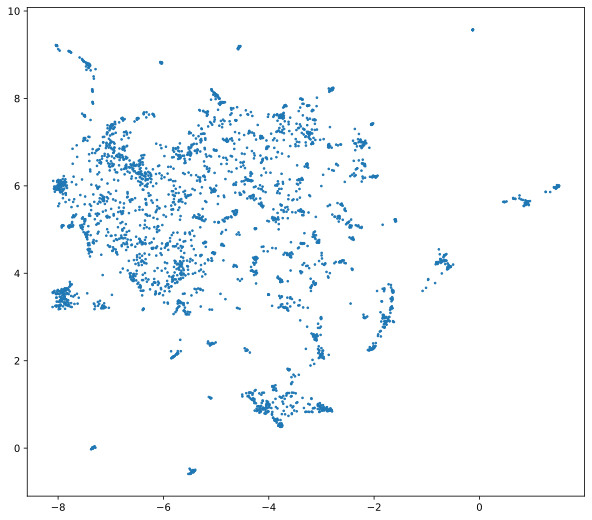

In [17]:
!pip install umap-learn
import umap.umap_ as umap # need to "pip install umap-learn"

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

Every dot in this plot is a product. As you can see, there are several tiny clusters of these datapoints. These are groups of similar products.

## Start Recommending Products
Congratulations! We are finally ready with the word2vec embeddings for every product in our online retail dataset. Now our next step is to suggest similar products for a certain product or a product's vector. 

Let's first create a product-ID and product-description dictionary to easily map a product's description to its ID and vice versa.

In [18]:
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [19]:
# test the dictionary
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

I have defined the function below. It will take a product's vector (n) as input and return top 6 similar products.

In [20]:
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.wv.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms        

Let's try out our function by passing the vector of the product '22728' ('ALARM CLOCK BAKELIKE PINK'). Here is the image I found on the web by googling 'ALARM CLOCK BAKELIKE PINK' (note a typo, which I haven't fixed). We'll load the image from the local folder:

Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks/EAI6010_Week3


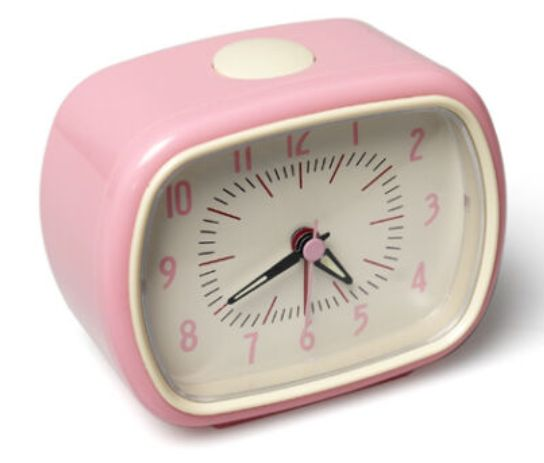

In [21]:
# from google.colab import files
# uploaded = files.upload()
#Image(filename='/content/drive/MyDrive/Colab Notebooks/EAI6010_Week3/alarm_clock__22728.PNG')
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/EAI6010_Week3/
Image(filename='alarm_clock__22728.jpg') # "As Googled on the web -  "Alarm Clock Bakelike Pink"

In [22]:
#similar_products(model['90019A']) # in the original
similar_products(model.wv['22728'])

[('ALARM CLOCK BAKELIKE GREEN', 0.8376388549804688),
 ('ALARM CLOCK BAKELIKE RED ', 0.8375091552734375),
 ('ALARM CLOCK BAKELIKE CHOCOLATE', 0.8289495706558228),
 ('ALARM CLOCK BAKELIKE IVORY', 0.8232215046882629),
 ('ALARM CLOCK BAKELIKE ORANGE', 0.8131182193756104),
 ('IVORY DINER WALL CLOCK', 0.5817769765853882)]

For the sake of curiosity I googled on image search and found this:

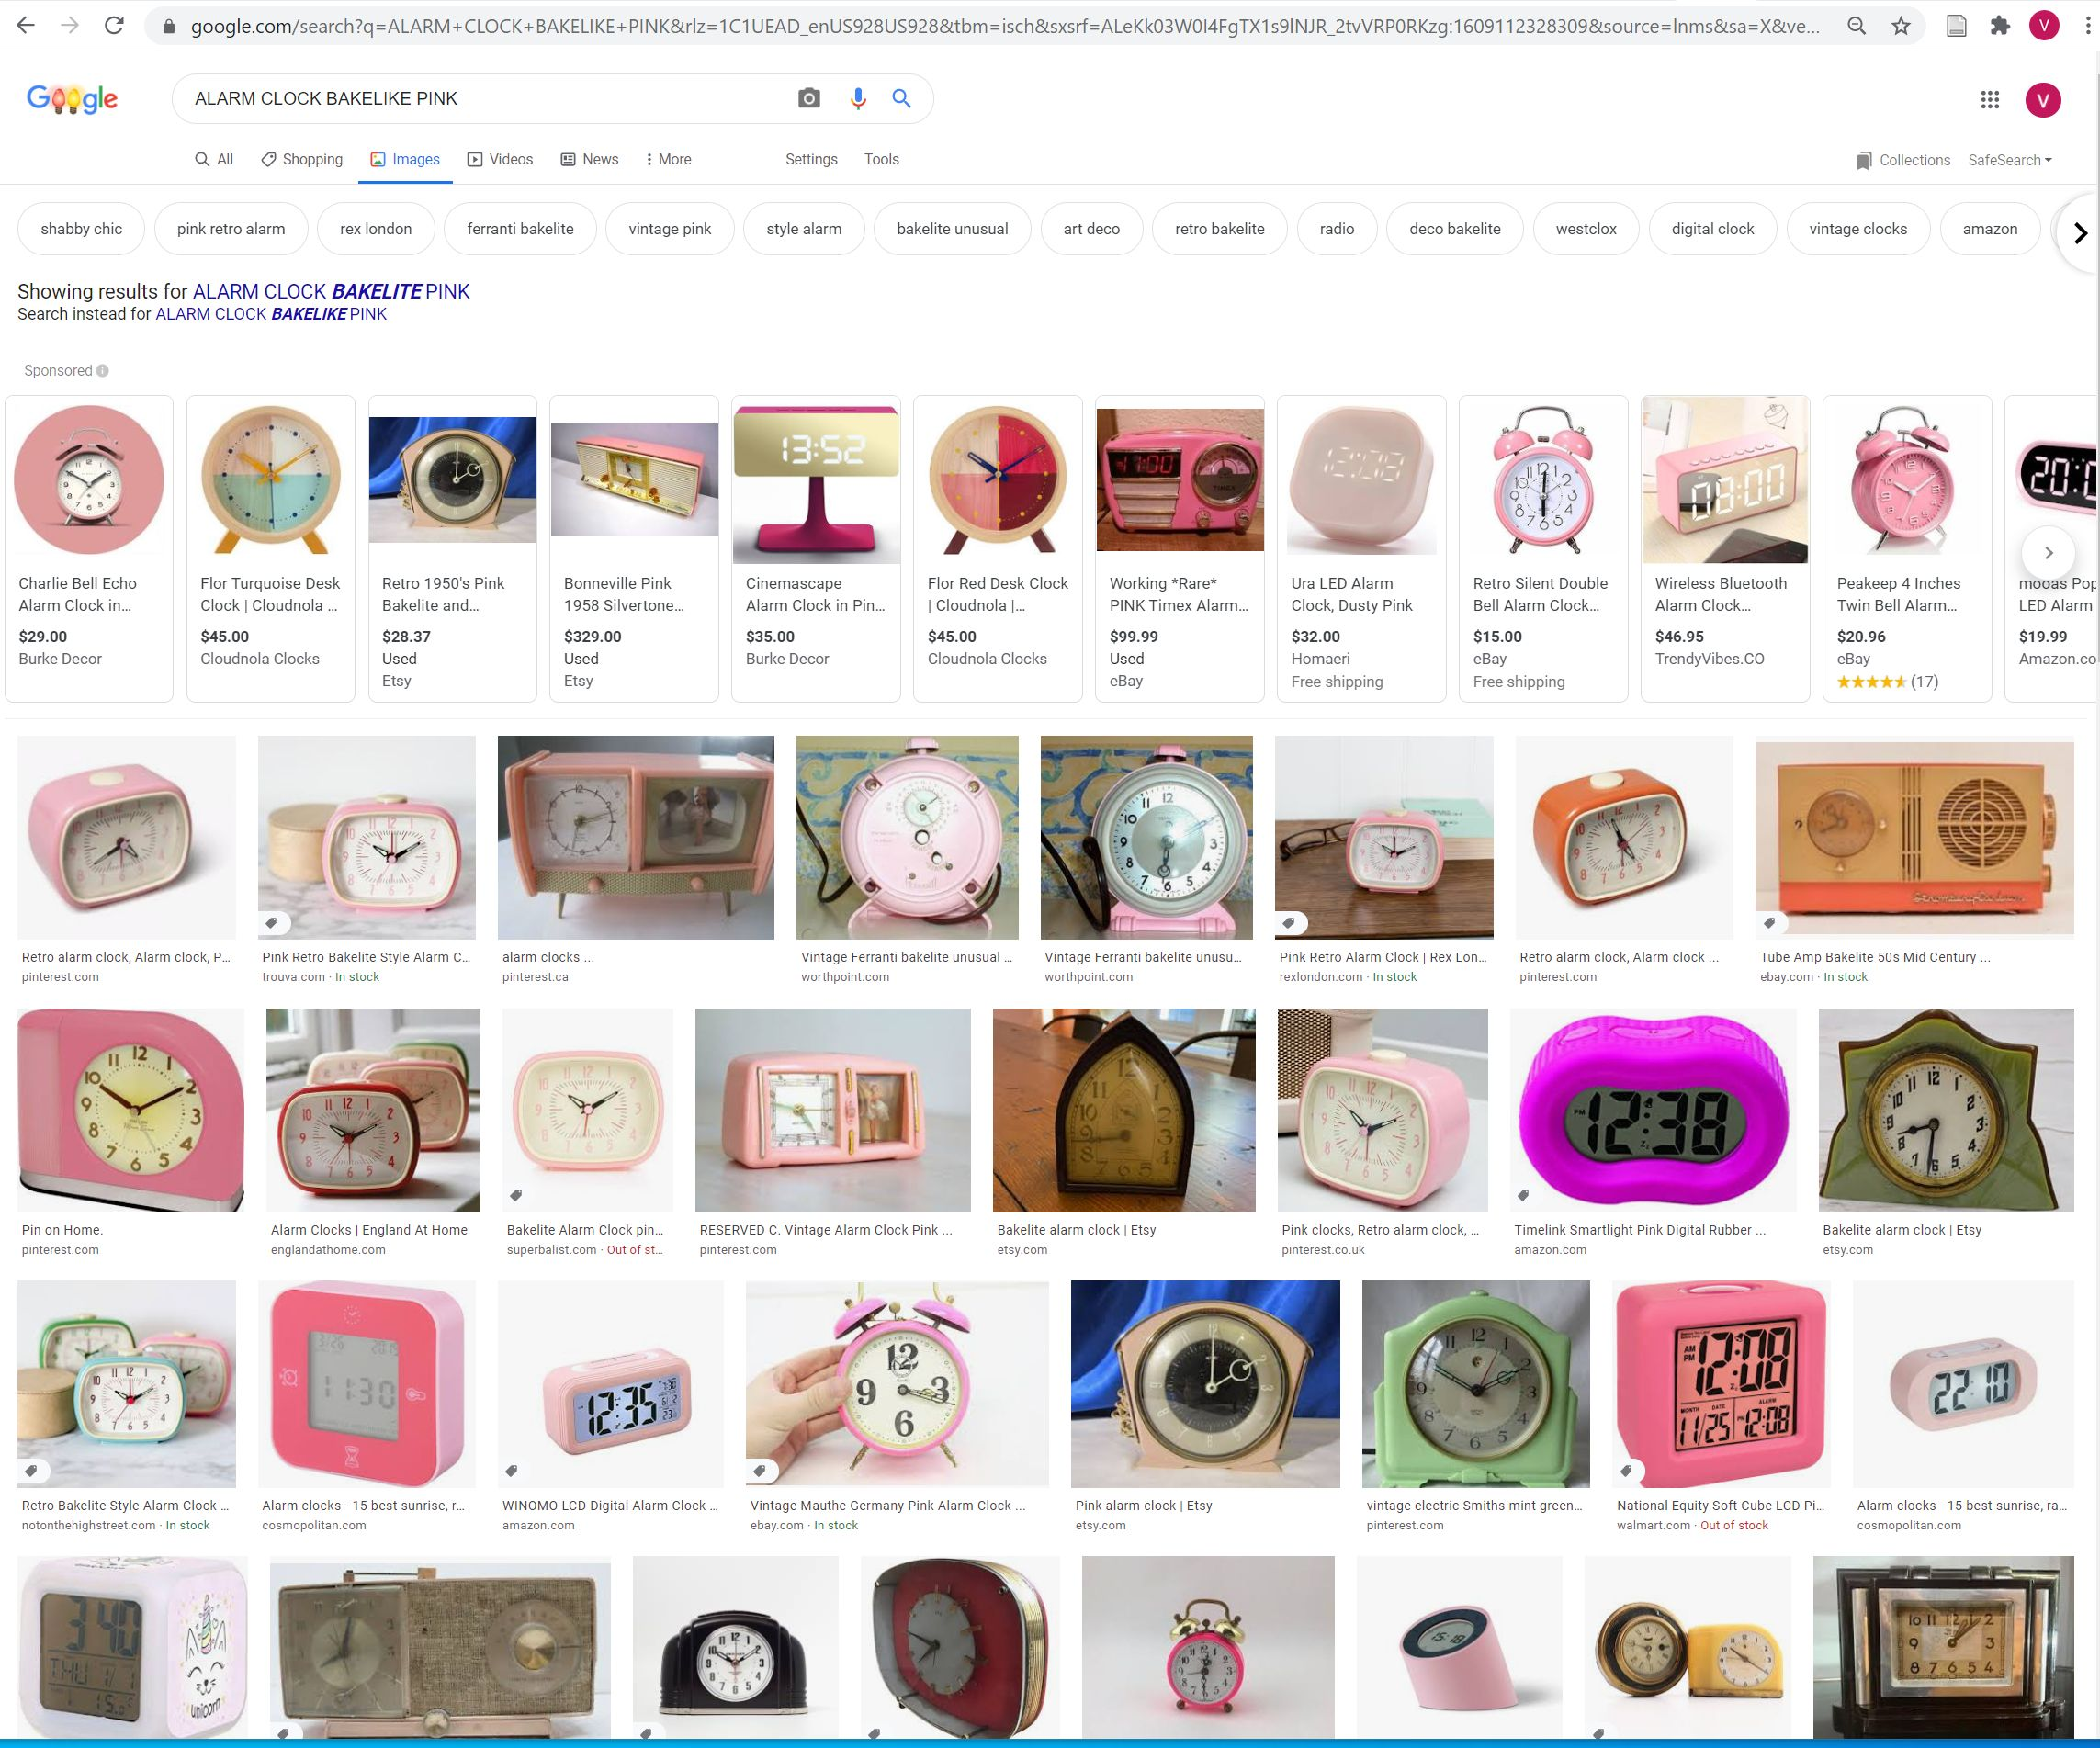

In [23]:
# uploaded = files.upload()
# Image(filename='google_image_search_query.PNG', width = 800, height = 600) # "Google image search results"
Image(filename='google_image_search_query.jpg', width = 800, height = 600) # "Google image search results"


Cool! The results are pretty relevant and match well with the input product. Even if no image information has been involved at all ! However, this output is based on the vector of a single product only. What if we want recommend a user products based on the multiple purchases he or she has made in the past?

One simple solution is to take average of all the vectors of the products he has bought so far and use this resultant vector to find similar products. For that we will use the function below that takes in a list of product ID's and gives out a 100 dimensional vector which is mean of vectors of the products in the input list.

In [24]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model.wv[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

If you can recall, we have already created a separate list of purchase sequences for validation purpose. Now let's make use of that.

In [25]:
len(purchases_val[0])

359

The length of the first list of products purchased by a user is shown above. We will pass this products' sequence of the validation set to the function *aggregate_vectors*.

In [26]:
aggregate_vectors(purchases_val[0]).shape

(100,)

Well, the function has returned an array of 100 dimension. It means the function is working fine. Now we can use this result to get the most similar products. Let's do it.

In [27]:
similar_products(aggregate_vectors(purchases_val[0]))

[('RED RETROSPOT PICNIC BAG', 0.7325411438941956),
 ('JUMBO STORAGE BAG SUKI', 0.7322629690170288),
 ('TEATIME GEL PENS ASST', 0.7260973453521729),
 ('JUMBO STORAGE BAG SKULLS', 0.7137151956558228),
 ('LUNCH BAG RED RETROSPOT', 0.7134021520614624),
 ('JUMBO BAG PINK POLKADOT', 0.7113409042358398)]

As it turns out, our system has recommended 6 products based on the entire purchase history of a user. Moreover, if you want to get products suggestions based on the last few purchases only then also you can use the same set of functions.

Below I am giving only the last 10 products purchased as input.

Feel free to play this code, try to get product recommendation for more sequences from the validation set

In [28]:
similar_products(aggregate_vectors(purchases_val[0][-10:]))

[('JUMBO STORAGE BAG SKULLS', 0.7286869287490845),
 ('TOY TIDY PINK POLKADOT', 0.6997230648994446),
 ('JUMBO BAG RED RETROSPOT', 0.6937352418899536),
 ('JUMBO STORAGE BAG SUKI', 0.6863839030265808),
 ('JUMBO BAG VINTAGE DOILY ', 0.684726357460022),
 ('JUMBO BAG PINK POLKADOT', 0.671160101890564)]

In [29]:
# test the dictionary
print(products_dict['71053'])
print("Similar")
similar_products(model.wv['71053'])

['WHITE MOROCCAN METAL LANTERN']
Similar


[('FRENCH CARRIAGE LANTERN', 0.5949223041534424),
 ('CREAM HANGING HEART T-LIGHT HOLDER', 0.578803300857544),
 ('WHITE LOVEBIRD LANTERN', 0.5609183311462402),
 ('LANTERN CREAM GAZEBO ', 0.5581074357032776),
 ('HANGING MEDINA LANTERN SMALL', 0.5535380840301514),
 ('HANGING METAL HEART LANTERN', 0.5479233860969543)]

The code below shows how to render the notebook to PDF using `nbconvert`

In [30]:
%%capture
# rendering a quality pdf
#!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
#from colab_pdf import colab_pdf
!pip install nbconvert==6.4.2

def colab_pdf(file_name, notebookpath="/content/drive/MyDrive/Colab Notebooks/"):
    import os

    # Checking if file_name passed is a string.
    if not isinstance(file_name, str):
        raise TypeError(
            f"expected a string as file_name, but got {type(file_name)} instead."
        )

    # Using the defaults used by google.colab
    drive_mount_point = "/content/drive/"
    gdrive_home = os.path.join(drive_mount_point, "My Drive/")

    # If the drive is not already mounted, attempt to mount it.
    if not os.path.isdir(gdrive_home):
        from google.colab import drive

        drive.mount(drive_mount_point)

    # Check if the notebook exists in the Drive.
    if not os.path.isfile(os.path.join(notebookpath, file_name)):
        raise ValueError(f"file '{file_name}' not found in path '{notebookpath}'.")

    # Installing all the recommended packages.
    get_ipython().system(
        "apt update >> /dev/null && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended >> /dev/null"
    )

    # If pdf with the same name exists, remove it.
    pdf_file = os.path.join(gdrive_home, file_name.split(".")[0] + ".pdf")
    
    if os.path.isfile(pdf_file):
        os.remove(pdf_file)

    # Attempt to convert to pdf and save it in Gdrive home dir using jupyter nbconvert command.
    try:
        get_ipython().system(
            "jupyter nbconvert --output-dir='$gdrive_home' '$notebookpath''$file_name' --to pdf"
        )
    except:
        return "nbconvert error"

    return "File ready to be Downloaded and Saved to Drive"

colab_pdf('EAI6010_Week3/EAI6010_NLP_Product_Recommender__Tutorial_Week3.ipynb')